https://www.kaggle.com/code/ekhtiar/resunet-a-baseline-on-tensorflow/notebook
https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/resunet.py

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, Add
from keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split
from utilities import DataGeneratorOnlyMask
import matplotlib.pyplot as plt

In [2]:
CHECKPOINT_NAME = 'resunet.h5'
KERNEL_INITIALIZER = 'he_normal'
PROJECT_PATH = os.getcwd()

IMG_SIZE = 256
BATCH_SIZE = 16
MAX_EPOCHS = 30
LEARNING_RATE = 0.05
EPSILON = 0.1

In [3]:
os.chdir('data/Healthcare AI Datasets/Brain_MRI')
brains = pd.read_csv('train.csv')
brains_test = pd.read_csv('test.csv')

In [4]:
brains_tumor = brains[brains['mask'] == 1]

X_train, X_val = train_test_split(brains_tumor, test_size=0.15, random_state=2020)

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)

test_ids = list(brains_test.image_path)
test_mask = list(brains_test.mask_path)

training_generator = DataGeneratorOnlyMask(train_ids, train_mask, img_h = IMG_SIZE, img_w = IMG_SIZE, batch_size = BATCH_SIZE)
validation_generator = DataGeneratorOnlyMask(val_ids, val_mask,  img_h = IMG_SIZE, img_w = IMG_SIZE, batch_size = BATCH_SIZE)
test_generator = DataGeneratorOnlyMask(test_ids, test_mask,  img_h = IMG_SIZE, img_w = IMG_SIZE, batch_size = BATCH_SIZE)

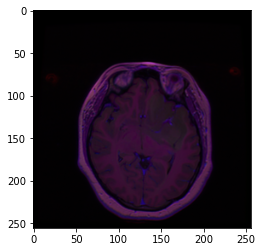

In [5]:
X, y = validation_generator.__getitem__(0)

plt.imshow(X[0])

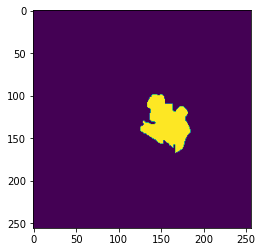

In [6]:
plt.imshow(y[0])

In [ ]:
#ResUNet
def resblock(X, f):
    X_copy = X

    X = Conv2D(f, kernel_size=(1, 1), strides=(1, 1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    X_copy = Conv2D(f, kernel_size=(1, 1), strides=(1, 1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X


def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge


def build_resunet(input_shape=(256, 256, 3)):
    X_input = Input(input_shape)

    conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
    conv1_in = BatchNormalization()(conv1_in)
    conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_in)
    conv1_in = BatchNormalization()(conv1_in)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv1_in)

    conv2_in = resblock(pool_1, 32)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv2_in)

    conv3_in = resblock(pool_2, 64)
    pool_3 = MaxPool2D(pool_size=(2, 2))(conv3_in)

    conv4_in = resblock(pool_3, 128)
    pool_4 = MaxPool2D(pool_size=(2, 2))(conv4_in)

    conv5_in = resblock(pool_4, 256)

    up_1 = upsample_concat(conv5_in, conv4_in)
    up_1 = resblock(up_1, 128)

    up_2 = upsample_concat(up_1, conv3_in)
    up_2 = resblock(up_2, 64)

    up_3 = upsample_concat(up_2, conv2_in)
    up_3 = resblock(up_3, 32)

    up_4 = upsample_concat(up_3, conv1_in)
    up_4 = resblock(up_4, 16)

    output = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(up_4)

    model_seg = Model(inputs=X_input, outputs=output)

    return model_seg

In [8]:
# Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = keras.flatten(y_true)
    y_pred_pos = keras.flatten(y_pred)
    true_pos = keras.sum(y_true_pos * y_pred_pos)
    false_neg = keras.sum(y_true_pos * (1-y_pred_pos))
    false_pos = keras.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7

    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return keras.pow((1-pt_1), gamma)

In [ ]:
#Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, monitor='val_tversky', mode='max')

filepath = PROJECT_PATH + '/resunets/' + CHECKPOINT_NAME
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True, monitor='val_tversky', mode='max')

In [ ]:
shape = (IMG_SIZE, IMG_SIZE, 3)
model = build_resunet(shape)

model.summary()

In [9]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon = EPSILON),
            loss=focal_tversky_loss, metrics=[tversky])

In [11]:
history = model.fit(training_generator,
                    epochs=MAX_EPOCHS,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_cb, checkpointer])

Epoch 1/30
72/72 [==============================] - ETA: 0s - loss: 0.8466 - tversky: 0.1981
Epoch 1: val_tversky improved from -inf to 0.15909, saving model to /home/studio-lab-user/sagemaker-studiolab-notebooks/tumor_detector/resunets/resunet.h5
72/72 [==============================] - 125s 2s/step - loss: 0.8466 - tversky: 0.1981 - val_loss: 0.8781 - val_tversky: 0.1591
Epoch 2/30
72/72 [==============================] - ETA: 0s - loss: 0.5264 - tversky: 0.5704
Epoch 2: val_tversky improved from 0.15909 to 0.36936, saving model to /home/studio-lab-user/sagemaker-studiolab-notebooks/tumor_detector/resunets/resunet.h5
72/72 [==============================] - 122s 2s/step - loss: 0.5264 - tversky: 0.5704 - val_loss: 0.7066 - val_tversky: 0.3694
Epoch 3/30
72/72 [==============================] - ETA: 0s - loss: 0.4062 - tversky: 0.6969
Epoch 3: val_tversky improved from 0.36936 to 0.49613, saving model to /home/studio-lab-user/sagemaker-studiolab-notebooks/tumor_detector/resunets/resun

0.87

In [ ]:
model.evaluate(test_generator)

In [ ]:
model.evaluate(validation_generator)

In [ ]:
model.evaluate(training_generator)

In [ ]:
def plot_predict(batch, prediction, batch_size = 16):
    fig, axs = plt.subplots(batch_size, 3, figsize=(batch_size, batch_size*3))

    for i in range(batch_size):
        axs[i][0].title.set_text("MRI del Cerebro")
        axs[i][0].imshow(batch[0][i])

        axs[i][1].title.set_text("Tumor real" )
        axs[i][1].imshow(batch[1][i])

        axs[i][2].title.set_text("Tumor detectado")
        axs[i][2].imshow(prediction[i])


    fig.tight_layout()

In [12]:
test_batch = test_generator.__getitem__(0)
test_predict = model.predict(test_batch[0])

plot_predict(test_batch, test_predict, BATCH_SIZE)

1/1 [==============================] - 1s 854ms/step


In [ ]:
train_batch = training_generator.__getitem__(0)
train_predict = model.predict(train_batch[0])

plot_predict(train_batch, train_predict, BATCH_SIZE)

In [16]:
model.save(PROJECT_PATH + '/resunet_last.h5')